TESTING FEATURE ENGINEERING AND LOGISTIC REGRESSION:

1 ==All data points==
a) All features
b) Only pre-processed features
c) Only raw features

2 ==Removing outliers==
a) All features
b) Only pre-processed features
c) Only raw features

3 ==Removing the features with more than 70% missing values==
a) All features
b) Only pre-processed features
c) Only raw features

4 ==Removing the features with more than 30% missing values==
a) All features
b) Only pre-processed features
c) Only raw features


TAKE THE BEST SCORE OF THOSE AND TRY FEATURE ENGINEERING WITH THIS SET

Skewness transformation
Removing one item from correlated pairs of features



In [1]:
import numpy as np
import p1lib.p1lib as ml
import proj1_helpers
from Unas_code import functions as unatools
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
y, X, ids=proj1_helpers.load_csv_data('train.csv')
y=np.expand_dims(y, axis=1)
x,_,__=ml.standardise(X)
tx=ml.augment_data(np.array(x))

In [3]:
#DEFINE A FUNCTION THAT DIRECTLY CALCULATES THE SCORE
def calculate_classification_error(y, tx, w, plotting=0):
    """ Calculates the classification error from the predicted outcomes. Assigns y_pred to classes then calculates class. error"""
    y_pred=np.dot(tx,w)
    class_pred=unatools.predictionsToClasses(y, y_pred, plotting)
    classification_error=unatools.calcResultsStatistics(y, class_pred)
    return classification_error

def calculate_classification_accuracy(y, tx, w):
    class_error=calculate_classification_error(y, tx, w)
    return 1-class_error
    

In [4]:
#Split data between training and test
x_train, y_train, x_test, y_test=ml.split_data(tx, y, 0.8, seed=42)

In [5]:
k_fold=4


def crossval_gamma(x, y, kfold, lambda_, gammas, w_ini, max_iter, seed):
    k_indices=ml.build_k_indices(y, k_fold, seed=42)
    all_indices = np.arange(len(y))


    tr_scores = []
    te_scores = []
    for g in gammas:
        tmp_tr_score=[]
        tmp_te_score=[]
        for k in range(k_fold):
            test_indices = k_indices[k]
            train_indices = [i for i in all_indices if i not in test_indices]
            x_test, y_test = x[test_indices], y[test_indices]
            x_train, y_train = x[train_indices], y[train_indices]
            
            w_tr, _=ml.reg_logistic_regression(y_train, x_train, lambda_, w_ini, max_iter, g)
            tr_score=calculate_classification_accuracy(y_train, x_train, w_tr)
            te_score=calculate_classification_accuracy(y_test, x_test, w_tr)
            
            tmp_tr_score.append(tr_score)
            tmp_te_score.append(te_score)
        mean_tr_score=np.mean(tmp_tr_score)
        mean_te_score=np.mean(tmp_te_score)
        print('gamma: %f, training score: %f, test score: %f' %(g, mean_tr_score, mean_te_score))
        tr_scores.append(mean_tr_score)
        te_scores.append(mean_te_score)

    gamma_opt=gammas[np.argmax(te_scores)]
    max_score=np.max(te_scores)
    return gamma_opt, max_score

def crossval_lambda(x, y, kfold, lambdas, gamma, w_ini, max_iter, seed):
    k_indices=ml.build_k_indices(y, k_fold, seed=42)
    all_indices = np.arange(len(y))


    tr_scores = []
    te_scores = []
    for l in lambdas:
        tmp_tr_score=[]
        tmp_te_score=[]
        for k in range(k_fold):
            test_indices = k_indices[k]
            train_indices = [i for i in all_indices if i not in test_indices]
            x_test, y_test = x[test_indices], y[test_indices]
            x_train, y_train = x[train_indices], y[train_indices]
            
            w_tr, _=ml.reg_logistic_regression(y_train, x_train, l, w_ini, max_iter, gamma)
            tr_score=calculate_classification_accuracy(y_train, x_train, w_tr)
            te_score=calculate_classification_accuracy(y_test, x_test, w_tr)
            
            tmp_tr_score.append(tr_score)
            tmp_te_score.append(te_score)
            
        mean_tr_score=np.mean(tmp_tr_score)
        mean_te_score=np.mean(tmp_te_score)
        print('lambda: %f, training score: %f, test score: %f' %(l, mean_tr_score, mean_te_score))
        tr_scores.append(mean_tr_score)
        te_scores.append(mean_te_score)

    lambda_opt=lambdas[np.argmax(te_scores)]
    max_score=np.max(te_scores)
    return lambda_opt, max_score

def crossval(x, y, kfold, lambda_, gamma, w_ini, max_iter, seed, batch_size):
    k_indices=ml.build_k_indices(y, k_fold, seed=seed)
    all_indices = np.arange(len(y))


    tr_scores = []
    te_scores = []
    for k in range(k_fold):
        test_indices = k_indices[k]
        train_indices = [i for i in all_indices if i not in test_indices]
        x_te, y_te = x[test_indices], y[test_indices]
        x_tr, y_tr = x[train_indices], y[train_indices]
            
        #w_tr, _=ml.reg_logistic_regression(y_tr, x_tr, lambda_, w_ini, max_iter, gamma)
        w_tr, _=ml.stochastic_reg_logistic_regression(y_tr, x_tr, lambda_, w_ini, max_iter, gamma, batch_size)
        tr_score=calculate_classification_accuracy(y_tr, x_tr, w_tr)
        te_score=calculate_classification_accuracy(y_te, x_te, w_tr)
            
        tr_scores.append(tr_score)
        te_scores.append(te_score)
            
    mean_tr_score=np.mean(tr_scores)
    mean_te_score=np.mean(te_scores)
    print('lambda: %f, gamma: %f, training score: %f, test score: %f' %(lambda_,gamma, mean_tr_score, mean_te_score))
    return mean_te_score, mean_tr_score


    

In [6]:
def crossval_grid(x_train, y_train, x_test, y_test, kfold, lambdas, gammas, w_ini, max_iter, seed, batch_size):
    gs=[]
    ls=[]
    scores=[]
    for l in lambdas:
        for g in gammas:
            print('lambda: %f, opt. gamma: %f' %(l, g))
            gs.append(g)
            ls.append(l)
            score,_=crossval(x_train, y_train, kfold, l, g, w_ini, max_iter, seed, batch_size)
            scores.append(score)
    opt_g, opt_l, best_score=gs[np.argmax(scores)], ls[np.argmax(scores)], np.max(scores)
    print('Crossvalidation best score: %f, opt. lambda: %f, opt. gamma: %f' %(best_score, opt_l, opt_g))
    #opt_weights,_=ml.reg_logistic_regression(y_train, x_train, opt_l, np.zeros((x_train.shape[1],1)), 2000, opt_g)
    opt_weights, _=ml.stochastic_reg_logistic_regression(y_train, x_train, opt_l, w_ini, max_iter, opt_g, batch_size)
    test_score=calculate_classification_accuracy(y_test, x_test, opt_weights)
    print('Test score for optimised parameters: %f' %test_score)
    return opt_l, opt_g, test_score


In [7]:
def crossval_grid2(x_train, y_train, x_test, y_test, kfold, lambdas, gammas, w_ini, max_iter, seed, batch_size):
    gs=[]
    ls=[]
    scores=[]
    train_scoremap=np.zeros((len(lambdas), len(gammas)))
    test_scoremap=np.zeros((len(lambdas), len(gammas)))
    i=0
 
    for l in lambdas:
        j=0
        for g in gammas:
            print('lambda: %f, opt. gamma: %f' %(l, g))
            gs.append(g)
            ls.append(l)
            te_score, tr_score=crossval(x_train, y_train, kfold, l, g, w_ini, max_iter, seed, batch_size)
            scores.append(te_score)
            train_scoremap[i,j]=tr_score
            test_scoremap[i,j]=te_score
            j+=1
        i+=1
    opt_g, opt_l, best_score=gs[np.argmax(scores)], ls[np.argmax(scores)], np.max(scores)
    print('Crossvalidation best score: %f, opt. lambda: %f, opt. gamma: %f' %(best_score, opt_l, opt_g))
    #opt_weights,_=ml.reg_logistic_regression(y_train, x_train, opt_l, w_ini, 2000, opt_g)
    opt_weights, _=ml.stochastic_reg_logistic_regression(y_train, x_train, opt_l, w_ini, max_iter, opt_g, batch_size)

    
    #train_score=calculate_classification_accuracy(y_train, x_train, opt_weights)
    test_score=calculate_classification_accuracy(y_test, x_test, opt_weights)
    
    
    plt.subplot(211)
    plt.contourf(gammas, lambdas, train_scoremap, 10)
    plt.xlabel('gamma')
    plt.ylabel('lambda')
    plt.colorbar()
    plt.subplot(212)
    plt.contourf(gammas, lambdas, test_scoremap, 10)
    plt.xlabel('gamma')
    plt.ylabel('lambda')
    plt.colorbar()
    plt.show()
    
    print('Test score for optimised parameters: %f' %test_score)
    return opt_l, opt_g, test_score

lambda: 0.000000, opt. gamma: 0.010000
Current iteration=0, loss=3.4883372537412827
Current iteration=100, loss=2.4516024351505
Current iteration=200, loss=1.1421336680604555
Current iteration=0, loss=2.7143283825473703
Current iteration=100, loss=1.8263724311436245
Current iteration=200, loss=0.778905385527133
Current iteration=0, loss=1.4868190232897405
Current iteration=100, loss=0.8026757062204607
Current iteration=200, loss=0.010285436172692926
Current iteration=0, loss=4.581015956000686
Current iteration=100, loss=3.0145074361599793
Current iteration=200, loss=0.9547792653844048
lambda: 0.000000, gamma: 0.010000, training score: 0.666667, test score: 0.620000
lambda: 0.000000, opt. gamma: 0.050000
Current iteration=0, loss=3.4883372537412827
Current iteration=100, loss=-1.8538733598273036
Current iteration=200, loss=-3.737128922720267
Current iteration=0, loss=2.7143283825473703
Current iteration=100, loss=-1.674196091563673
Current iteration=200, loss=-4.016213062399716
Current 

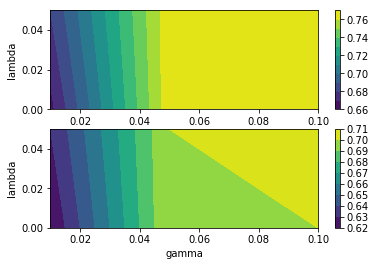

Test score for optimised parameters: 0.740000


(0.05, 0.1, 0.74)

In [8]:
x_toy_tr=x_train[:100,:]
y_toy_tr=y_train[:100,:]
x_toy_te=x_test[:100,:]
y_toy_te=y_test[:100,:]
lambdas=np.array([0, 0.05])
gammas=np.array([0.01, 0.05, 0.1])
w_ini=np.ones((x_toy_tr.shape[1],1))
crossval_grid2(x_toy_tr, y_toy_tr, x_toy_te, y_toy_te, 4, lambdas, gammas, w_ini, 300, 42, 50)

lambda: 0.000000, opt. gamma: 0.010000
Current iteration=0, loss=3.2944568959918326
Current iteration=100, loss=2.692457754660153
Current iteration=200, loss=1.6818587105553706
Current iteration=300, loss=0.5049826691532248
Current iteration=400, loss=-0.5606023583497232
Current iteration=500, loss=-1.2242353805382131
Current iteration=600, loss=-1.7298261277511573
Current iteration=700, loss=-2.1747857052077126
Current iteration=800, loss=-2.5685842700884556
Current iteration=900, loss=-2.919677605055412
Current iteration=0, loss=3.248756509077315
Current iteration=100, loss=2.6534497280627565
Current iteration=200, loss=1.7082013360218418
Current iteration=300, loss=0.48466927746576643
Current iteration=400, loss=-0.5439284432530547
Current iteration=500, loss=-1.2428223770087896
Current iteration=600, loss=-1.7680209431125262
Current iteration=700, loss=-2.222544589283309
Current iteration=800, loss=-2.6176536938942707
Current iteration=900, loss=-2.982982077020297
Current iteration

Current iteration=400, loss=-2.6913412308043814
Current iteration=500, loss=-2.8124709654787003
Current iteration=600, loss=-2.906795722558846
Current iteration=700, loss=-2.9890403148053952
Current iteration=800, loss=-3.009140477244594
Current iteration=900, loss=-2.9895278403528565
Current iteration=0, loss=3.248756509077315
Current iteration=100, loss=-1.0520289300272616
Current iteration=200, loss=-2.044454575397538
Current iteration=300, loss=-2.478084147342808
Current iteration=400, loss=-2.7551046343594003
Current iteration=500, loss=-2.9201123771580906
Current iteration=600, loss=-3.0135626550355217
Current iteration=700, loss=-3.03660925238197
Current iteration=800, loss=-3.048501040055927
Current iteration=900, loss=-3.076798383776994
Current iteration=0, loss=3.249531323212322
Current iteration=100, loss=-1.0794795024522201
Current iteration=200, loss=-2.062345781677928
Current iteration=300, loss=-2.5491226345172895
Current iteration=400, loss=-2.786306566188638
Current it

Current iteration=700, loss=-1.4890100515418632
Current iteration=800, loss=-1.4645940678888305
Current iteration=900, loss=-1.4553778441567158
Current iteration=0, loss=3.248756509077315
Current iteration=100, loss=-1.2643850955405564
Current iteration=200, loss=-1.4755759191277111
Current iteration=300, loss=-1.4747628987356485
Current iteration=400, loss=-1.5548706125308174
Current iteration=500, loss=-1.5527166128382879
Current iteration=600, loss=-1.516599927968574
Current iteration=700, loss=-1.4815728585425
Current iteration=800, loss=-1.491587914226527
Current iteration=900, loss=-1.5138980740795132
Current iteration=0, loss=3.249531323212322
Current iteration=100, loss=-1.275457058662291
Current iteration=200, loss=-1.4834942415385448
Current iteration=300, loss=-1.5440750436722583
Current iteration=400, loss=-1.5258587964531056
Current iteration=500, loss=-1.352885875260809
Current iteration=600, loss=-1.3999953049887108
Current iteration=700, loss=-1.4616681764369892
Current

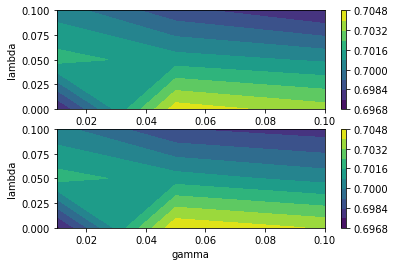

Test score for optimised parameters: 0.702080


(0.0, 0.05, 0.70208)

In [9]:
lambdas=np.array([0, 0.05, 0.1])
gammas=np.array([0.01, 0.05, 0.1])
w_ini=np.ones((x_train.shape[1],1))
crossval_grid2(x_train, y_train, x_test, y_test, 4, lambdas, gammas, w_ini, 1000, 42, 50)

In [10]:
#w_ini=np.zeros((tx.shape[1],1))
#lambdas=np.logspace(-6,0, num=7)
#lambdas=np.array([0, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5])
#lambda_opt, score=crossval_lambda(x_train, y_train, 4, lambdas, 1e-2, w_ini, 1000, 42)

In [11]:
#print('lambda opt: %f' %lambda_opt)
#gammas=np.logspace(-6, -2, num=5)
#gammas=np.array([0.005, 0.01, 0.025, 0.05])
#gamma_opt, score=crossval_gamma(x_train, y_train, 4, lambda_opt, gammas, w_ini, 1000, 42)

In [12]:
# DO THE CROSSVALIDATION WITH RESPECT TO THE CLASSIFICATION ERROR

In [13]:
#opt_weights,_=ml.reg_logistic_regression(y_train, x_train, lambda_opt, np.zeros((x_train.shape[1],1)), 2000, gamma_opt)


In [14]:
#score=calculate_classification_accuracy(y_test, x_test, opt_weights)
#print(score)

In [15]:
x_der_train, x_der_test =x_train[:,0:13], x_test[:,0:13]
x_raw_train, x_raw_test=x_train[:,14:], x_test[:, 14:]

In [16]:
lambdas=np.array([0, 0.05, 0.1])
gammas=np.array([0.01, 0.05, 0.1])
w_ini=np.ones((x_der_train.shape[1],1))
crossval_grid(x_der_train, y_train, x_der_test, y_test, 4, lambdas, gammas, w_ini, 1000, 42, 50)

lambda: 0.000000, opt. gamma: 0.010000
Current iteration=0, loss=2.391958334948985
Current iteration=100, loss=1.4986112707527692
Current iteration=200, loss=0.6191885582937362
Current iteration=300, loss=-0.16148870891458764
Current iteration=400, loss=-0.815422184630854
Current iteration=500, loss=-1.3152325158577558
Current iteration=600, loss=-1.7342671166755208
Current iteration=700, loss=-2.115617133682321
Current iteration=800, loss=-2.4654833863411034
Current iteration=900, loss=-2.7856989558648295
Current iteration=0, loss=2.3744599797362556
Current iteration=100, loss=1.492581071010033
Current iteration=200, loss=0.6355452690754423
Current iteration=300, loss=-0.16758875932919579
Current iteration=400, loss=-0.8222244108925879
Current iteration=500, loss=-1.3384086620374755
Current iteration=600, loss=-1.7666702149326645
Current iteration=700, loss=-2.150293956397414
Current iteration=800, loss=-2.5011706623483696
Current iteration=900, loss=-2.840862032860143
Current iterati

Current iteration=300, loss=-2.3363689872324462
Current iteration=400, loss=-2.5694034812125057
Current iteration=500, loss=-2.6969212327519814
Current iteration=600, loss=-2.787053301430221
Current iteration=700, loss=-2.8699501039084376
Current iteration=800, loss=-2.8816909779576108
Current iteration=900, loss=-2.866338017203526
Current iteration=0, loss=2.3744599797362556
Current iteration=100, loss=-1.0487052510838148
Current iteration=200, loss=-1.917740199407567
Current iteration=300, loss=-2.3406345200860375
Current iteration=400, loss=-2.6204270597288604
Current iteration=500, loss=-2.7853072838357145
Current iteration=600, loss=-2.86882079383484
Current iteration=700, loss=-2.8990032455290766
Current iteration=800, loss=-2.911171203257654
Current iteration=900, loss=-2.9428761105015915
Current iteration=0, loss=2.390547891218748
Current iteration=100, loss=-1.0638182542841979
Current iteration=200, loss=-1.9408878594395766
Current iteration=300, loss=-2.4262573699690377
Curre

Current iteration=700, loss=-1.4402237106298625
Current iteration=800, loss=-1.3904221565846333
Current iteration=900, loss=-1.3846814037579829
Current iteration=0, loss=2.3744599797362556
Current iteration=100, loss=-1.2280809189735
Current iteration=200, loss=-1.3947916911820413
Current iteration=300, loss=-1.4013785746858975
Current iteration=400, loss=-1.4780504142377813
Current iteration=500, loss=-1.491230117107302
Current iteration=600, loss=-1.441452417526054
Current iteration=700, loss=-1.4061044873418491
Current iteration=800, loss=-1.4165882532774046
Current iteration=900, loss=-1.4475193203961374
Current iteration=0, loss=2.390547891218748
Current iteration=100, loss=-1.197370285433178
Current iteration=200, loss=-1.4097706271706099
Current iteration=300, loss=-1.483249294629229
Current iteration=400, loss=-1.4514485436182851
Current iteration=500, loss=-1.3044239107448354
Current iteration=600, loss=-1.3381749636633142
Current iteration=700, loss=-1.3868876229656004
Curren

(0.0, 0.05, 0.69894)

In [17]:
lambdas=np.array([0, 0.05, 0.1])
gammas=np.array([0.01, 0.05, 0.1])
w_ini=np.ones((x_raw_train.shape[1],1))
crossval_grid(x_raw_train, y_train, x_raw_test, y_test, 4, lambdas, gammas, w_ini, 1000, 42, 50)

lambda: 0.000000, opt. gamma: 0.010000
Current iteration=0, loss=2.3558578312739655
Current iteration=100, loss=1.9529116604389216
Current iteration=200, loss=1.5285199157608615
Current iteration=300, loss=1.1729667322326491
Current iteration=400, loss=0.8935791140253164
Current iteration=500, loss=0.7638775417775804
Current iteration=600, loss=0.6855365058622304
Current iteration=700, loss=0.625093348795113
Current iteration=800, loss=0.580859159580179
Current iteration=900, loss=0.5548331078729726
Current iteration=0, loss=2.3159166881081834
Current iteration=100, loss=1.9751906061528754
Current iteration=200, loss=1.574702825062693
Current iteration=300, loss=1.175684924638752
Current iteration=400, loss=0.9200711655704576
Current iteration=500, loss=0.7850575668180472
Current iteration=600, loss=0.7024685161270853
Current iteration=700, loss=0.6318434015493254
Current iteration=800, loss=0.5820096547489062
Current iteration=900, loss=0.5541177118775472
Current iteration=0, loss=2.3

Current iteration=400, loss=0.5201312375895435
Current iteration=500, loss=0.5258959459837047
Current iteration=600, loss=0.5286458892613018
Current iteration=700, loss=0.5292585744375408
Current iteration=800, loss=0.5262878506461143
Current iteration=900, loss=0.5304012367935478
Current iteration=0, loss=2.3159166881081834
Current iteration=100, loss=0.649309935373879
Current iteration=200, loss=0.5231529814360317
Current iteration=300, loss=0.5201280448531894
Current iteration=400, loss=0.5145285758890854
Current iteration=500, loss=0.5194696319255638
Current iteration=600, loss=0.5154862344322041
Current iteration=700, loss=0.5190143650236061
Current iteration=800, loss=0.5129296520190455
Current iteration=900, loss=0.5124722485433261
Current iteration=0, loss=2.3159622913415108
Current iteration=100, loss=0.6129315745680319
Current iteration=200, loss=0.5207069014298608
Current iteration=300, loss=0.5172442001024313
Current iteration=400, loss=0.5213348793451521
Current iteration=

Current iteration=900, loss=0.557939375902265
Current iteration=0, loss=2.3159166881081834
Current iteration=100, loss=0.585168838698514
Current iteration=200, loss=0.5447393441523237
Current iteration=300, loss=0.561316541884213
Current iteration=400, loss=0.5403168282690676
Current iteration=500, loss=0.560632768224614
Current iteration=600, loss=0.5570870928637507
Current iteration=700, loss=0.5496871642825933
Current iteration=800, loss=0.5409094372228358
Current iteration=900, loss=0.5475868910880166
Current iteration=0, loss=2.3159622913415108
Current iteration=100, loss=0.5477617636082387
Current iteration=200, loss=0.5497679578374386
Current iteration=300, loss=0.555505070175798
Current iteration=400, loss=0.5555070309090382
Current iteration=500, loss=0.5857277708143442
Current iteration=600, loss=0.5649196393997815
Current iteration=700, loss=0.5541078457857407
Current iteration=800, loss=0.5537096281176994
Current iteration=900, loss=0.5590375839306542
Current iteration=0, l

(0.0, 0.1, 0.6533)

In [24]:
#RESOLVING 999s
y, X, ids=proj1_helpers.load_csv_data('train.csv')
y=np.expand_dims(y, axis=1)
tx_cleaned=unatools.resolve999values(X, 0, 0)

tx_cleaned,_,__=ml.standardise(tx_cleaned)
tx_cleaned=ml.augment_data(np.array(tx_cleaned))
x_cl_train, y_cl_train, x_cl_test, y_cl_test=ml.split_data(tx_cleaned, y, 0.8, seed=42)
x_clder_train, x_clder_test=x_cl_train[:,0:13], x_cl_test[:, 0:13]
x_clraw_train, x_clraw_test=x_cl_train[:,14:], x_cl_test[:, 14:]

Number of samples when at leas one feature has value -999: 181886
Percentage of total data:  0.727544


lambda: 0.000000, opt. gamma: 0.010000
Current iteration=0, loss=2.5163593018038712
Current iteration=100, loss=1.6838296783267241
Current iteration=200, loss=0.8911219592292537
Current iteration=300, loss=0.15031644496302354
Current iteration=400, loss=-0.5238325111987236
Current iteration=500, loss=-1.0710245503336941
Current iteration=600, loss=-1.5514726584914769
Current iteration=700, loss=-1.9928968935347229
Current iteration=800, loss=-2.386099420496748
Current iteration=900, loss=-2.7284842162186567
Current iteration=0, loss=2.4744566948914923
Current iteration=100, loss=1.6521761386458187
Current iteration=200, loss=0.8652861684123613
Current iteration=300, loss=0.12908883404550958
Current iteration=400, loss=-0.5375730386752445
Current iteration=500, loss=-1.0924809576387324
Current iteration=600, loss=-1.5738368057874776
Current iteration=700, loss=-2.015665628764796
Current iteration=800, loss=-2.413988991130016
Current iteration=900, loss=-2.785730805745635
Current iterati

Current iteration=300, loss=-2.332152915013635
Current iteration=400, loss=-2.565633971459558
Current iteration=500, loss=-2.6844557174258297
Current iteration=600, loss=-2.7593999288918565
Current iteration=700, loss=-2.8468982734044315
Current iteration=800, loss=-2.848488689655224
Current iteration=900, loss=-2.8332633948528025
Current iteration=0, loss=2.4744566948914923
Current iteration=100, loss=-0.9425333354140077
Current iteration=200, loss=-1.9424354298473216
Current iteration=300, loss=-2.3741688226622126
Current iteration=400, loss=-2.6469544800253426
Current iteration=500, loss=-2.791909728411486
Current iteration=600, loss=-2.843208684467683
Current iteration=700, loss=-2.881522312075003
Current iteration=800, loss=-2.8847520960889055
Current iteration=900, loss=-2.9317068757454825
Current iteration=0, loss=2.4944710833785724
Current iteration=100, loss=-1.0113133817642959
Current iteration=200, loss=-1.9703271258807873
Current iteration=300, loss=-2.4423330841105337
Curr

Current iteration=600, loss=-1.3950761525193953
Current iteration=700, loss=-1.4534501192521685
Current iteration=800, loss=-1.4060596708867033
Current iteration=900, loss=-1.395385382998244
Current iteration=0, loss=2.4744566948914923
Current iteration=100, loss=-1.2539080989511682
Current iteration=200, loss=-1.4153953183590977
Current iteration=300, loss=-1.4401924952846572
Current iteration=400, loss=-1.5248367635904125
Current iteration=500, loss=-1.4988637289601203
Current iteration=600, loss=-1.4318053470046472
Current iteration=700, loss=-1.4337574598329847
Current iteration=800, loss=-1.4269814678465003
Current iteration=900, loss=-1.4742908273749356
Current iteration=0, loss=2.4944710833785724
Current iteration=100, loss=-1.251479357468454
Current iteration=200, loss=-1.4438353503931045
Current iteration=300, loss=-1.5171412135070457
Current iteration=400, loss=-1.4911372590513656
Current iteration=500, loss=-1.337244428358239
Current iteration=600, loss=-1.3787634927441559
C

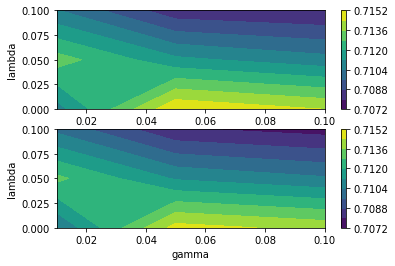

Test score for optimised parameters: 0.712060


(0.0, 0.05, 0.71206)

In [25]:
#ALL FEATURES WITH 999s REPLACED WITH FEATURE MEAN
lambdas=np.array([0, 0.05, 0.1])
gammas=np.array([0.01, 0.05, 0.1])
w_ini=np.ones((x_cl_train.shape[1],1))
crossval_grid2(x_cl_train, y_cl_train, x_cl_test, y_cl_test, 4, lambdas, gammas, w_ini, 1000, 42, 50)

In [28]:
max_iter=501

lambda: 0.000000, opt. gamma: 0.050000
Current iteration=0, loss=2.192632829448467
Current iteration=100, loss=-1.1553673696129518
Current iteration=200, loss=-2.8156675116969976
Current iteration=300, loss=-4.23046309596617
Current iteration=400, loss=-5.355414195403429
Current iteration=500, loss=-5.966270073976943
Current iteration=0, loss=2.1905166511143106
Current iteration=100, loss=-1.1907456080504382
Current iteration=200, loss=-2.8425566732366647
Current iteration=300, loss=-4.309369268833804
Current iteration=400, loss=-5.443800682464658
Current iteration=500, loss=-6.027263046588653
Current iteration=0, loss=2.2042112243268996
Current iteration=100, loss=-1.3084814800269213
Current iteration=200, loss=-2.923921741533707
Current iteration=300, loss=-4.349122430881389
Current iteration=400, loss=-5.4441889618695365
Current iteration=500, loss=-6.096407520927946
Current iteration=0, loss=2.195812998099315
Current iteration=100, loss=-1.2705853087072052
Current iteration=200, lo

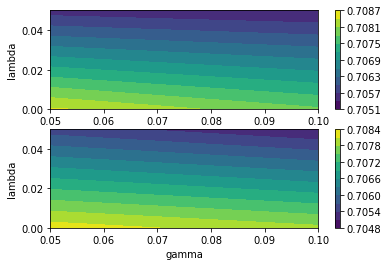

Test score for optimised parameters: 0.706920


(0.0, 0.05, 0.70692)

In [29]:
#DERIVED FEATURES WITH 999s REPLACED WITH FEATURE MEAN
lambdas=np.array([0, 0.05])
gammas=np.array([0.05, 0.1])
w_ini=np.ones((x_clder_train.shape[1],1))
crossval_grid2(x_clder_train, y_cl_train, x_clder_test, y_cl_test, 4, lambdas, gammas, w_ini, max_iter, 42, 50)

lambda: 0.000000, opt. gamma: 0.050000
Current iteration=0, loss=1.5153351708672265
Current iteration=100, loss=0.8938229612711208
Current iteration=200, loss=0.5998520001166662
Current iteration=300, loss=0.5223462246170857
Current iteration=400, loss=0.5022331536974615
Current iteration=500, loss=0.49478092716367605
Current iteration=0, loss=1.4732817642496587
Current iteration=100, loss=0.9012839539488258
Current iteration=200, loss=0.5862031924711741
Current iteration=300, loss=0.5035981211054326
Current iteration=400, loss=0.48149660704495423
Current iteration=500, loss=0.4757401080117635
Current iteration=0, loss=1.4838718509017594
Current iteration=100, loss=0.8615204694018721
Current iteration=200, loss=0.6008336217035699
Current iteration=300, loss=0.5136916031866791
Current iteration=400, loss=0.5022937358867589
Current iteration=500, loss=0.49724392985720345
Current iteration=0, loss=1.4910199734936398
Current iteration=100, loss=0.9090611538833989
Current iteration=200, los

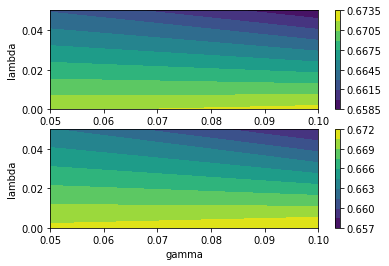

Test score for optimised parameters: 0.665000


(0.0, 0.1, 0.665)

In [30]:
#RAW FEATURES WITH 999s REPLACED WITH FEATURE MEAN
lambdas=np.array([0, 0.05])
gammas=np.array([0.05, 0.1])
w_ini=np.ones((x_clraw_train.shape[1],1))
crossval_grid2(x_clraw_train, y_cl_train, x_clraw_test, y_cl_test, 4, lambdas, gammas, w_ini, max_iter, 42, 50)

In [31]:
# RESOLVING 999s AND REMOVING OUTLIERS
y, X, ids=proj1_helpers.load_csv_data('train.csv')
y=np.expand_dims(y, axis=1)
tx_cleaned=unatools.resolve999values(X, 0, 0)
tx_cleaned=unatools.removeOutliers(tx_cleaned, 95)

tx_cleaned,_,__=ml.standardise(tx_cleaned)
tx_cleaned=ml.augment_data(np.array(x))
x_cl_train, y_cl_train, x_cl_test, y_cl_test=ml.split_data(tx_cleaned, y, 0.8, seed=42)

Number of samples when at leas one feature has value -999: 181886
Percentage of total data:  0.727544


lambda: 0.000000, opt. gamma: 0.050000
Current iteration=0, loss=3.2944568959918326
Current iteration=100, loss=-1.1824246356225616
Current iteration=200, loss=-3.217621901272974
Current iteration=300, loss=-4.447351916469898
Current iteration=400, loss=-5.258777849557025
Current iteration=500, loss=-5.662063990954277
Current iteration=0, loss=3.248756509077315
Current iteration=100, loss=-1.204312775834031
Current iteration=200, loss=-3.282878211664883
Current iteration=300, loss=-4.5654137379331035
Current iteration=400, loss=-5.239728254404712
Current iteration=500, loss=-5.727607778465665
Current iteration=0, loss=3.249531323212322
Current iteration=100, loss=-1.3730428207930592
Current iteration=200, loss=-3.3484671841271605
Current iteration=300, loss=-4.55675496676342
Current iteration=400, loss=-5.340827425075787
Current iteration=500, loss=-5.810231896785654
Current iteration=0, loss=3.2528340139842546
Current iteration=100, loss=-1.3046296881903783
Current iteration=200, loss

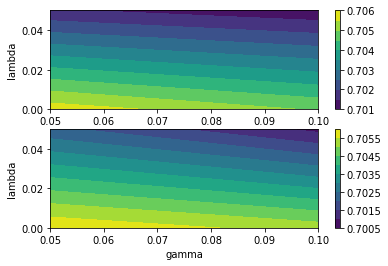

Test score for optimised parameters: 0.701260


(0.0, 0.05, 0.70126)

In [32]:
#ALL FEATURES WITH 999s REPLACED WITH FEATURE MEAN AND OUTLIERS REMOVED
lambdas=np.array([0, 0.05])
gammas=np.array([0.05, 0.1])
w_ini=np.ones((x_cl_train.shape[1],1))
crossval_grid2(x_cl_train, y_cl_train, x_cl_test, y_cl_test, 4, lambdas, gammas, w_ini, max_iter, 42, 50)

In [37]:
#RESOLVING 999s, REMOVING OUTLIERS AND REMOVING FEATURES WITH MORE THAN 50% OF MISSING VALUES
y, X, ids=proj1_helpers.load_csv_data('train.csv')
y=np.expand_dims(y, axis=1)
toremove=np.array([28, 27, 26, 12, 6, 5, 4])
X_cleaned=np.delete(X, toremove, axis=1)
tx_cleaned=unatools.resolve999values(X_cleaned, 0, 0)

tx_cleaned,_,__=ml.standardise(tx_cleaned)
tx_cleaned=ml.augment_data(np.array(tx_cleaned))
x_cl_train, y_cl_train, x_cl_test, y_cl_test=ml.split_data(tx_cleaned, y, 0.8, seed=42)
x_clder_train, x_clder_test=x_cl_train[:,0:13], x_cl_test[:, 0:13]
x_clraw_train, x_clraw_test=x_cl_train[:,14:], x_cl_test[:, 14:]

Number of samples when at leas one feature has value -999: 111904
Percentage of total data:  0.447616


lambda: 0.000000, opt. gamma: 0.050000
Current iteration=0, loss=2.796936873756395
Current iteration=100, loss=-0.9460935293180468
Current iteration=200, loss=-2.829173680780327
Current iteration=300, loss=-4.256357408186266
Current iteration=400, loss=-5.302222535127569
Current iteration=500, loss=-5.807626784331541
Current iteration=0, loss=2.764108133342013
Current iteration=100, loss=-0.9478016795235622
Current iteration=200, loss=-2.888575394133801
Current iteration=300, loss=-4.3556842090370695
Current iteration=400, loss=-5.3984618670386615
Current iteration=500, loss=-5.894166907661034
Current iteration=0, loss=2.787197757718169
Current iteration=100, loss=-1.1158816473073083
Current iteration=200, loss=-2.9478310637887373
Current iteration=300, loss=-4.386276823051118
Current iteration=400, loss=-5.39882679080324
Current iteration=500, loss=-5.971529428085527
Current iteration=0, loss=2.780245301323891
Current iteration=100, loss=-1.0650848861511448
Current iteration=200, loss

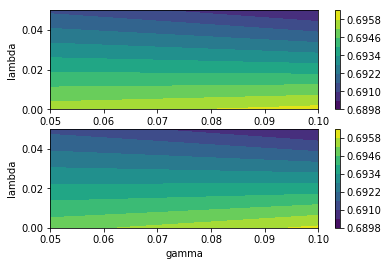

Test score for optimised parameters: 0.691560


(0.0, 0.1, 0.69156)

In [38]:
#ALL FEATURES WITH >50% of 999s REMOVED, OTHER -999s REPLACED WITH FEATURE MEAN AND OUTLIERS REMOVED
lambdas=np.array([0, 0.05])
gammas=np.array([0.05, 0.1])
w_ini=np.ones((x_cl_train.shape[1],1))
crossval_grid2(x_cl_train, y_cl_train, x_cl_test, y_cl_test, 4, lambdas, gammas, w_ini, max_iter, 42, 50)

In [39]:
#RESOLVING 999s, REMOVING OUTLIERS AND REMOVING FEATURES WITH MORE THAN 25% OF MISSING VALUES
y, X, ids=proj1_helpers.load_csv_data('train.csv')
y=np.expand_dims(y, axis=1)
toremove=np.array([28, 27, 26, 25, 24, 23, 12, 6, 5, 4])
X_cleaned=np.delete(X, toremove, axis=1)
tx_cleaned=unatools.resolve999values(X_cleaned, 0, 0)

tx_cleaned,_,__=ml.standardise(tx_cleaned)
tx_cleaned=ml.augment_data(np.array(tx_cleaned))
x_cl_train, y_cl_train, x_cl_test, y_cl_test=ml.split_data(tx_cleaned, y, 0.8, seed=42)
x_clder_train, x_clder_test=x_cl_train[:,0:13], x_cl_test[:, 0:13]
x_clraw_train, x_clraw_test=x_cl_train[:,14:], x_cl_test[:, 14:]

Number of samples when at leas one feature has value -999: 38114
Percentage of total data:  0.152456


lambda: 0.000000, opt. gamma: 0.050000
Current iteration=0, loss=2.7967868632898365
Current iteration=100, loss=-1.0344953659146652
Current iteration=200, loss=-2.850714439182661
Current iteration=300, loss=-4.2716094426115
Current iteration=400, loss=-5.314071602236317
Current iteration=500, loss=-5.81852379321199
Current iteration=0, loss=2.7679141010598793
Current iteration=100, loss=-1.0390491119203542
Current iteration=200, loss=-2.9085592722362708
Current iteration=300, loss=-4.368428455283521
Current iteration=400, loss=-5.403894725696754
Current iteration=500, loss=-5.89658064363893
Current iteration=0, loss=2.791707654432054
Current iteration=100, loss=-1.1966091720208767
Current iteration=200, loss=-2.96957949376952
Current iteration=300, loss=-4.4001743059003395
Current iteration=400, loss=-5.411870831050591
Current iteration=500, loss=-5.9763869365517
Current iteration=0, loss=2.78315746163328
Current iteration=100, loss=-1.1423444217786798
Current iteration=200, loss=-3.01

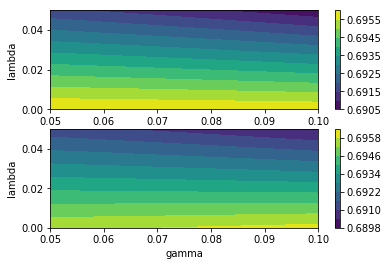

Test score for optimised parameters: 0.691460


(0.0, 0.1, 0.69146)

In [40]:
#ALL FEATURES WITH >25% of 999s REMOVED, OTHER -999s REPLACED WITH FEATURE MEAN AND OUTLIERS REMOVED
lambdas=np.array([0, 0.05])
gammas=np.array([0.05, 0.1])
w_ini=np.ones((x_cl_train.shape[1],1))
crossval_grid2(x_cl_train, y_cl_train, x_cl_test, y_cl_test, 4, lambdas, gammas, w_ini, max_iter, 42, 50)

In [41]:
#RESOLVING 999s, REMOVING OUTLIERS AND REMOVING FEATURES WITH MORE THAN 25% OF MISSING VALUES AND APPLYING SKEWNESS TRANSFORM
from tools_PT import skewness_correction
y, X, ids=proj1_helpers.load_csv_data('train.csv')
y=np.expand_dims(y, axis=1)
toremove=np.array([28, 27, 26, 25, 24, 23, 12, 6, 5, 4])
X_cleaned=np.delete(X, toremove, axis=1)
tx_cleaned=unatools.resolve999values(X_cleaned, 0, 0)
tx_cleaned=skewness_correction(tx_cleaned)

tx_cleaned,_,__=ml.standardise(tx_cleaned)
tx_cleaned=ml.augment_data(np.array(tx_cleaned))
x_cl_train, y_cl_train, x_cl_test, y_cl_test=ml.split_data(tx_cleaned, y, 0.8, seed=42)
x_clder_train, x_clder_test=x_cl_train[:,0:13], x_cl_test[:, 0:13]
x_clraw_train, x_clraw_test=x_cl_train[:,14:], x_cl_test[:, 14:]

Number of samples when at leas one feature has value -999: 38114
Percentage of total data:  0.152456


lambda: 0.000000, opt. gamma: 0.050000
Current iteration=0, loss=2.951987815000769
Current iteration=100, loss=-1.3579116263101834
Current iteration=200, loss=-3.3013085015014987
Current iteration=300, loss=-4.612911951575869
Current iteration=400, loss=-5.363405704687929
Current iteration=500, loss=-5.628942384232607
Current iteration=0, loss=2.933220438193319
Current iteration=100, loss=-1.3705244589723156
Current iteration=200, loss=-3.3398195410835947
Current iteration=300, loss=-4.709605900933116
Current iteration=400, loss=-5.394763033368069
Current iteration=500, loss=-5.727743002901572
Current iteration=0, loss=2.9457445558664888
Current iteration=100, loss=-1.5091035816673553
Current iteration=200, loss=-3.4002602228722636
Current iteration=300, loss=-4.708049314649891
Current iteration=400, loss=-5.427924960570514
Current iteration=500, loss=-5.795547242665935
Current iteration=0, loss=2.9557690175646822
Current iteration=100, loss=-1.5005941852433773
Current iteration=200, l

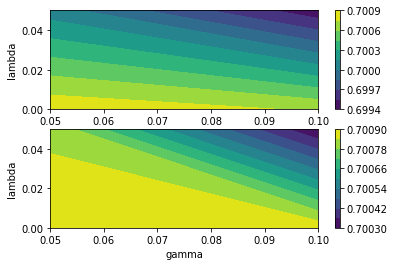

Test score for optimised parameters: 0.697820


(0.0, 0.05, 0.69782)

In [42]:
#ALL FEATURES WITH >25% of 999s REMOVED, OTHER -999s REPLACED WITH FEATURE MEAN AND OUTLIERS REMOVED AND SKEWNESS TRANSFORM
lambdas=np.array([0, 0.05])
gammas=np.array([0.05, 0.1])
w_ini=np.ones((x_cl_train.shape[1],1))
crossval_grid2(x_cl_train, y_cl_train, x_cl_test, y_cl_test, 4, lambdas, gammas, w_ini, max_iter, 42, 50)

Correlations:
    0 - 2 (linear)
    4 - 5 (linear)
    4 - 6 (nonlinear)
    5 - 6 (nonlinear)
    9 - 23 (linear)
    9 - 29 (linear)
    23 - 29 (linear)
    
To remove correlated features and keep max information we should remove 0, 4, 9, 23. BUT 4 and 23 are features with 25% or more -999s
So compared to last step, we only need to remove 0 and 9
    

In [43]:
#RESOLVING 999s, REMOVING OUTLIERS AND REMOVING FEATURES WITH MORE THAN 25% OF MISSING VALUES AND APPLYING SKEWNESS TRANSFORM AND REMOVING CORRELATED FEATURES
from tools_PT import skewness_correction
y, X, ids=proj1_helpers.load_csv_data('train.csv')
y=np.expand_dims(y, axis=1)
toremove=np.array([28, 27, 26, 25, 24, 23, 12,9, 6, 5, 4,0])
X_cleaned=np.delete(X, toremove, axis=1)
tx_cleaned=unatools.resolve999values(X_cleaned, 0, 0)
tx_cleaned=skewness_correction(tx_cleaned)

tx_cleaned,_,__=ml.standardise(tx_cleaned)
tx_cleaned=ml.augment_data(np.array(tx_cleaned))
x_cl_train, y_cl_train, x_cl_test, y_cl_test=ml.split_data(tx_cleaned, y, 0.8, seed=42)
x_clder_train, x_clder_test=x_cl_train[:,0:13], x_cl_test[:, 0:13]
x_clraw_train, x_clraw_test=x_cl_train[:,14:], x_cl_test[:, 14:]

Number of samples when at leas one feature has value -999: 0
Percentage of total data:  0.0


lambda: 0.000000, opt. gamma: 0.050000
Current iteration=0, loss=2.8446660343222505
Current iteration=100, loss=-1.359232889380534
Current iteration=200, loss=-3.2300460119660426
Current iteration=300, loss=-4.557058231737272
Current iteration=400, loss=-5.351024543833311
Current iteration=500, loss=-5.680809707991821
Current iteration=0, loss=2.828383975187509
Current iteration=100, loss=-1.3852337499235459
Current iteration=200, loss=-3.2671758533285704
Current iteration=300, loss=-4.643264912454024
Current iteration=400, loss=-5.40091012017113
Current iteration=500, loss=-5.763984246284003
Current iteration=0, loss=2.8340563747390024
Current iteration=100, loss=-1.5108213538557325
Current iteration=200, loss=-3.3227873116783946
Current iteration=300, loss=-4.656998178781727
Current iteration=400, loss=-5.421210328082855
Current iteration=500, loss=-5.822100607277233
Current iteration=0, loss=2.851133956729182
Current iteration=100, loss=-1.4963548759648648
Current iteration=200, los

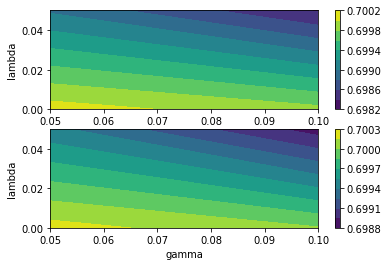

Test score for optimised parameters: 0.697100


(0.0, 0.05, 0.6971)

In [44]:
#ALL FEATURES WITH >25% of 999s REMOVED, OTHER -999s REPLACED WITH FEATURE MEAN AND OUTLIERS REMOVED AND SKEWNESS TRANSFORM AND REMOVING CORRELATED FEATURES
lambdas=np.array([0, 0.05])
gammas=np.array([0.05, 0.1])
w_ini=np.ones((x_cl_train.shape[1],1))
crossval_grid2(x_cl_train, y_cl_train, x_cl_test, y_cl_test, 4, lambdas, gammas, w_ini, max_iter, 42, 50)